In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from google.colab import drive

In [38]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
clinical_data = pd.read_csv('/content/drive/My Drive/Projects/multi-view/clinical.csv')

genetic_data = pd.read_csv('/content/drive/My Drive/Projects/multi-view/genetic.csv')

In [40]:
clinical_data.isnull().sum()

,0
participant_id,0
diagnosis,0
roi0,0
roi1,0
roi2,0
...,...
roi140,0
roi141,0
roi142,0
roi143,0


In [41]:
genetic_data.isnull().sum()

,0
participant_id,0
SNP0,0
SNP1,0
SNP2,0
SNP3,0
...,...
SNP95,0
SNP96,0
SNP97,0
SNP98,0


In [42]:
# Merge the datasets on 'participant_id' to ensure both clinical and genetic data have matching participants
merged_data = pd.merge(clinical_data, genetic_data, on='participant_id', how='inner')

# Extract clinical and genetic data matrices
X = merged_data.iloc[:, 2:2 + len(clinical_data.columns) - 1].values
Z = merged_data.iloc[:, 2 + len(clinical_data.columns):].values

In [43]:
X.shape, Z.shape

((1200, 146), (1200, 98))

In [44]:
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

Z_scaler = StandardScaler()
Z_scaled = Z_scaler.fit_transform(Z)

In [45]:

np.random.seed(42)

K = 2
lambda_w = 0.01
lambda_s = 0.001
max_iter = 200

V = np.random.rand(X.shape[1], K)  # Clinical data weight matrix
W = np.random.rand(Z.shape[1], K)  # Genetic data weight matrix

U = np.zeros((X.shape[0], K))
for i in range(X.shape[0]):
    U[i, np.random.randint(0, K)] = 1  # Assign each participant to one cluster

# Initialize the residual matrix S (for clustering component)
S = np.zeros_like(X)


In [46]:
def softmax(x):
    # If x is 1D, reshape to 2D for consistent axis handling
    if x.ndim == 1:
        x = x.reshape(1, -1)

    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


In [47]:
def update_U(X, V, W, S, Z_scaled, K):
    N = X.shape[0]
    U = np.zeros((N, K))

    # Precompute logits for all samples (N x K)
    logits = Z_scaled @ W

    for i in range(N):

        sample_logits = logits[i]


        softmax_probs = softmax(sample_logits)  # Automatically reshaped to (1, K)
        softmax_probs = softmax_probs.ravel()  # Flatten back to (K,) for simplicity

        min_loss = float('inf')
        best_k = -1

        for k in range(K):

            clustering_loss = np.linalg.norm(X[i] - V[:, k] - S[i]) ** 2

            classification_loss = -np.log(np.maximum(softmax_probs[k], 1e-10))

            total_loss = clustering_loss + classification_loss

            if total_loss < min_loss:
                min_loss = total_loss
                best_k = k

        U[i, best_k] = 1

    return U


In [48]:
import numpy as np

def update_V(X, U, S, regularization_strength=1e-6):

    UUT = U.T @ U

    # Add regularization to the diagonal (ridge regression term)
    UUT += np.eye(UUT.shape[0]) * regularization_strength

    # Use the pseudo-inverse in case U^T * U is not invertible
    try:
        V = (X - S).T @ U @ np.linalg.pinv(UUT)
    except np.linalg.LinAlgError as e:
        print("Matrix inversion error:", e)
        V = None

    return V


In [49]:
def update_W(Z, U, W, lambda_w, learning_rate=0.001, max_iter=50):
    N = Z.shape[0]
    K = W.shape[1]

    for i in range(max_iter):
        gradient = np.zeros_like(W)

        # Compute the gradient for all samples and clusters
        for k in range(K):
            zi = Z
            ui_k = U[:, k]

            sigmoid = 1 / (1 + np.exp(-zi @ W[:, k]))

            gradient[:, k] = zi.T @ (sigmoid - ui_k) / N

        # Update weights with regularization
        W -= learning_rate * (gradient + lambda_w * np.sign(W))


    return W


In [50]:
def update_S(X, V, U):
    S = X - (V @ U.T).T
    return S

In [51]:
def classification_loss(U, logits):
    probs = softmax(logits)
    return -np.sum(U * np.log(probs + 1e-12))  # Add small epsilon to avoid log(0)


In [52]:
def compute_loss(X, V, W, U, S, Z_scaled, lambda_w):

    clustering_loss = np.linalg.norm(X - (V @ U.T).T - S, ord='fro')**2

    logits = Z_scaled @ W
    classification_loss_value = classification_loss(U, logits)

    # Regularization for weights (L1-norm of W)
    reg_loss = lambda_w * np.sum(np.abs(W))

    # Regularization for residuals (Frobenius norm of S)
    reg_s_loss = lambda_s * np.linalg.norm(S, 'fro')**2

    total_loss = clustering_loss + classification_loss_value + reg_loss + reg_s_loss

    return total_loss


In [53]:
import matplotlib.pyplot as plt

losses = []

for iteration in range(max_iter):
    print(f"Iteration {iteration + 1}/{max_iter}")

    V = update_V(X_scaled, U, S)
    W = update_W(Z_scaled, U, W, lambda_w)
    S = update_S(X_scaled, V, U)
    U = update_U(X, V, W, S, Z_scaled, K)


    # Compute and store the loss
    loss = compute_loss(X_scaled, V, W, U, S, Z_scaled, lambda_w)
    losses.append(loss)



Iteration 1/200
Iteration 2/200
Iteration 3/200
Iteration 4/200
Iteration 5/200
Iteration 6/200
Iteration 7/200
Iteration 8/200
Iteration 9/200
Iteration 10/200
Iteration 11/200
Iteration 12/200
Iteration 13/200
Iteration 14/200
Iteration 15/200
Iteration 16/200
Iteration 17/200
Iteration 18/200
Iteration 19/200
Iteration 20/200
Iteration 21/200
Iteration 22/200
Iteration 23/200
Iteration 24/200
Iteration 25/200
Iteration 26/200
Iteration 27/200
Iteration 28/200
Iteration 29/200
Iteration 30/200
Iteration 31/200
Iteration 32/200
Iteration 33/200
Iteration 34/200
Iteration 35/200
Iteration 36/200
Iteration 37/200
Iteration 38/200
Iteration 39/200
Iteration 40/200
Iteration 41/200
Iteration 42/200
Iteration 43/200
Iteration 44/200
Iteration 45/200
Iteration 46/200
Iteration 47/200
Iteration 48/200
Iteration 49/200
Iteration 50/200
Iteration 51/200
Iteration 52/200
Iteration 53/200
Iteration 54/200
Iteration 55/200
Iteration 56/200
Iteration 57/200
Iteration 58/200
Iteration 59/200
Iterat

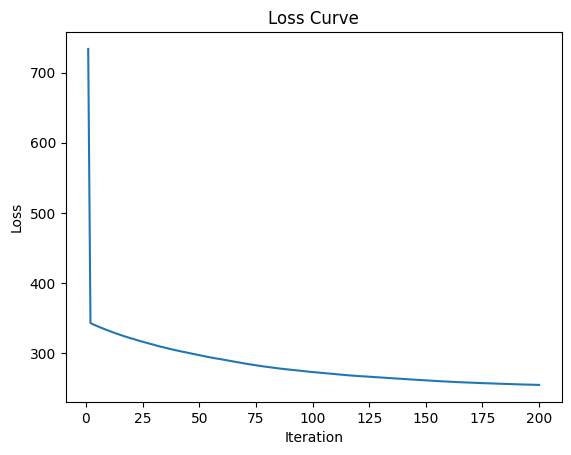

In [54]:
# Plot the loss curve
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()